In [65]:
# import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np   # data processing
import matplotlib.pyplot as plt  # Data visualization
from tqdm import tqdm # Progress bar


print("Libraries imported successfully")

Libraries imported successfully


In [20]:
import os
import pandas as pd


# load the train dataset
root_dir = "C:/Users/infaw/Downloads/Chest X-ray lab 3/xray_dataset_covid19/train/"
sub_folders = ['PNEUMONIA', 'NORMAL']
labels = [0, 1]

train_data = []

for s, l in zip(sub_folders, labels):
    for r, d, f in os.walk(root_dir + s):
        for file in f:
            if ".jpeg" or ".jpg" in file:
                train_data.append((os.path.join(s,file), l))
                
train_df = pd.DataFrame(train_data, columns = ['filename', 'label'])

In [21]:
train_df.head(10)  # view the first 10 train set

,filename,label
0,PNEUMONIA\01E392EE-69F9-4E33-BFCE-E5C968654078...,0
1,PNEUMONIA\1-s2.0-S0140673620303706-fx1_lrg.jpg,0
2,PNEUMONIA\1-s2.0-S1684118220300608-main.pdf-00...,0
3,PNEUMONIA\1-s2.0-S1684118220300608-main.pdf-00...,0
4,PNEUMONIA\1-s2.0-S1684118220300682-main.pdf-00...,0
5,PNEUMONIA\1-s2.0-S1684118220300682-main.pdf-00...,0
6,PNEUMONIA\1-s2.0-S1684118220300682-main.pdf-00...,0
7,PNEUMONIA\1-s2.0-S1684118220300682-main.pdf-00...,0
8,PNEUMONIA\1312A392-67A3-4EBF-9319-810CF6DA5EF6...,0
9,PNEUMONIA\171CB377-62FF-4B76-906C-F3787A01CB2E...,0


In [22]:
train_df.tail(10)  # view the first 10 train set

,filename,label
138,NORMAL\IM-0111-0001.jpeg,1
139,NORMAL\NORMAL2-IM-0007-0001.jpeg,1
140,NORMAL\NORMAL2-IM-0012-0001.jpeg,1
141,NORMAL\NORMAL2-IM-0013-0001.jpeg,1
142,NORMAL\NORMAL2-IM-0023-0001.jpeg,1
143,NORMAL\NORMAL2-IM-0027-0001.jpeg,1
144,NORMAL\NORMAL2-IM-0028-0001.jpeg,1
145,NORMAL\NORMAL2-IM-0029-0001.jpeg,1
146,NORMAL\NORMAL2-IM-0030-0001.jpeg,1
147,NORMAL\NORMAL2-IM-0033-0001.jpeg,1


<Axes: xlabel='label', ylabel='count'>

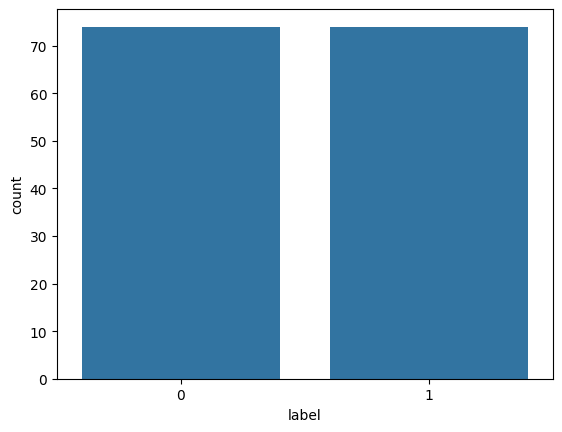

In [24]:
# visualize the number of NORMAL and PNEUMONIA cases using the seaborn
import seaborn as sns

sns.countplot(data = train_df, x = 'label')

In [17]:
# load the test dataset
root_dir = "C:/Users/infaw/Downloads/Chest X-ray lab 3/xray_dataset_covid19/test/"
sub_folders = ['PNEUMONIA', 'NORMAL']
labels = [0, 1]

test_data = []

for s, l in zip(sub_folders, labels):
    for r, d, f in os.walk(root_dir + s):
        for file in f:
            if ".jpeg" or ".jpg" in file:
                test_data.append((os.path.join(s,file), l))
                
test_df = pd.DataFrame(test_data, columns = ['filename', 'label'])



In [18]:
test_df.head(10)  # view the firt 10 test set


,filename,label
0,PNEUMONIA\ryct.2020200034.fig2.jpeg,0
1,PNEUMONIA\ryct.2020200034.fig5-day0.jpeg,0
2,PNEUMONIA\ryct.2020200034.fig5-day4.jpeg,0
3,PNEUMONIA\ryct.2020200034.fig5-day7.jpeg,0
4,PNEUMONIA\SARS-10.1148rg.242035193-g04mr34g0-F...,0
5,PNEUMONIA\SARS-10.1148rg.242035193-g04mr34g0-F...,0
6,PNEUMONIA\SARS-10.1148rg.242035193-g04mr34g0-F...,0
7,PNEUMONIA\SARS-10.1148rg.242035193-g04mr34g04a...,0
8,PNEUMONIA\SARS-10.1148rg.242035193-g04mr34g04b...,0
9,PNEUMONIA\SARS-10.1148rg.242035193-g04mr34g05x...,0


In [19]:

test_df.tail(10) # view the last 10 test set

,filename,label
30,NORMAL\NORMAL2-IM-0112-0001.jpeg,1
31,NORMAL\NORMAL2-IM-0117-0001.jpeg,1
32,NORMAL\NORMAL2-IM-0120-0001.jpeg,1
33,NORMAL\NORMAL2-IM-0123-0001.jpeg,1
34,NORMAL\NORMAL2-IM-0130-0001.jpeg,1
35,NORMAL\NORMAL2-IM-0131-0001.jpeg,1
36,NORMAL\NORMAL2-IM-0132-0001.jpeg,1
37,NORMAL\NORMAL2-IM-0139-0001.jpeg,1
38,NORMAL\NORMAL2-IM-0145-0001.jpeg,1
39,NORMAL\NORMAL2-IM-0171-0001.jpeg,1


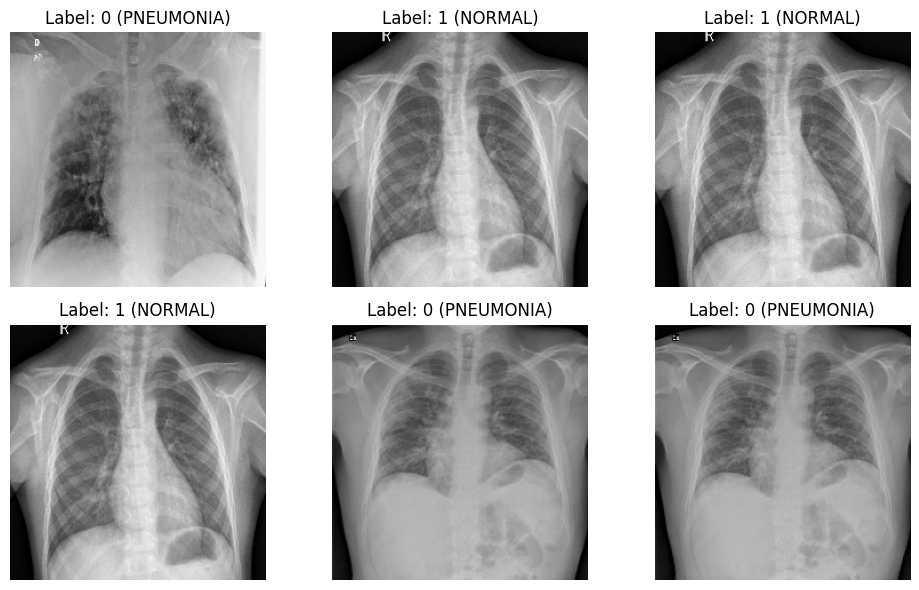

In [54]:
# visualize the test dataset
import random

fig, ax = plt.subplots(2, 3, figsize = (10, 6))

random_idx = np.random.randint(1, len(train_data),size = 6)
idx = 0

for i in range(2):
    for j in range(3):
        
        label = train_df.label[random_idx[idx]]
        file_path = os.path.join(root_dir, train_df.filename[random_idx[idx]])
        
        # read an image with OpenCV
        img = cv2.imread(file_path, 1)
        
        # resize the image
        img = cv2.resize(img, (224, 224))
        
        ax[i, j].imshow(img)
        ax[i, j].set_title(f"Label: {label} ({'NORMAL' if label == 1 else 'PNEUMONIA'})")
        ax[i, j].axis('off')
        idx = i + 1
        
plt.tight_layout()
plt.show()

In [62]:
from types import SimpleNamespace
cfg = SimpleNamespace(**{})


# load the train set and preprocess it
cfg.root_dir = root_dir
cfg.image_size = 224

class CustomDataset(Dataset):
    def __init__(self, cfg, df, transform=None, mode='val'):
        self.root_dir = cfg.root_dir
        self.df = df
        self.filename = df['filename'].values
        self.labels = df['label'].values
        
        if transform:
            self.transform = transform
        else:
            self.transform = A.Compose([
                A.Resize(cfg.image_size, cfg.image_size),
                ToTensorV2(),
            ])
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = os.path.join(self.root_dir, self.filename[idx])
        
        # Read an image as RGB with OpenCV
        img = cv2.imread(file_path, 1)
        
        # apply augmentation
        augmented = self.transform(image = img)
        img = augmented['image']
        
        # Normalize 
        img = img/223
        
        return img, label

In [63]:
# load the dataset using the DataLoader

cfg.batch_size = 32

train_dataset = CustomDataset(cfg, train_df)

train_dataloader = DataLoader(train_dataset, batch_size = cfg.batch_size, shuffle = True, num_workers = 0)

In [64]:
# Iterate over the DataLoader to get the batches sample
for (image_batch, label_batch) in train_dataloader:
    print(image_batch.shape)
    print(label_batch.shape)
    
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [66]:
# split the training set into training and validation

trainSet,valSet = random_split(train_df, lengths=[0.8, 0.2])

In [69]:
# Load the training
train_dataset = CustomDataset(cfg, trainSet.dataset)
valid_dataset = CustomDataset(cfg, valSet.dataset)

train_dataloader = DataLoader(train_dataset, batch_size = cfg.batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = cfg.batch_size, shuffle = False)